In [4]:
# Data manipulation
import pandas as pd
import numpy as np
from numpy.linalg import multi_dot
import yfinance as yf

from scipy.stats import norm
from tabulate import tabulate

# Import matplotlib for visualization
import matplotlib
import matplotlib.pyplot as plt

# Plot settings
plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = [12.0, 8.0]
matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['lines.linewidth'] = 2.0

In [9]:
df = pd.DataFrame(yf.download(['AAPL', 'AMZN', 'FB', 'GOOG', 'NFLX']))['Adj Close']
df.tail(2)

[*********************100%***********************]  5 of 5 completed


,AAPL,AMZN,FB,GOOG,NFLX
Date,,,,,
2022-07-07,146.350006,116.330002,172.190002,2386.120117,189.270004
2022-07-08,147.039993,115.540001,170.880005,2403.370117,186.979996


In [10]:
# Calculate daily returns
returns = df.pct_change().dropna()

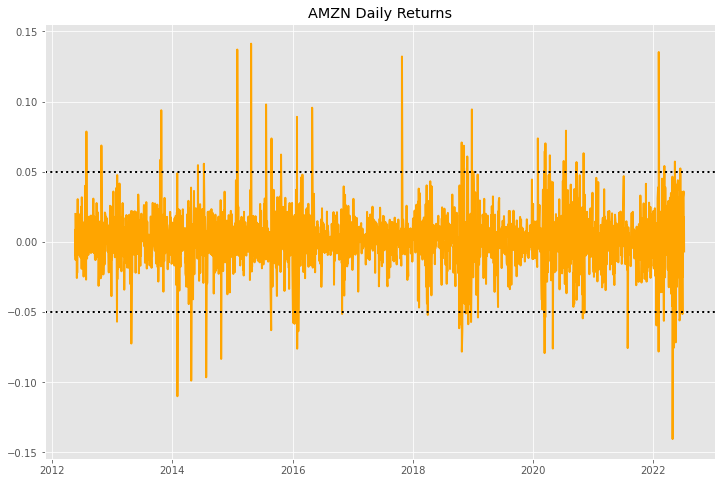

In [11]:
# Visualize AMZN daily returns
plt.plot(returns['AMZN'], color='orange')
plt.axhline(y=0.05, ls='dotted', color='black')
plt.axhline(y=-0.05, ls='dotted', color='black')
plt.title('AMZN Daily Returns')
plt.grid(True)

In [12]:
# Calculate mean and standard deviation 
mean = np.mean(returns['AMZN'])
stdev = np.std(returns['AMZN'])

# Calculate VaR at difference confidence level
VaR_90 = norm.ppf(1-0.90,mean,stdev)
VaR_95 = norm.ppf(1-0.95,mean,stdev) #norm.ppf(0.05)
VaR_99 = norm.ppf(1-0.99,mean,stdev)

In [13]:
VaR_99

-0.044873619198760976

In [14]:
norm.ppf(0.01)

-2.3263478740408408

In [15]:
# Ouput results in tabular format
table = [['90%', VaR_90],['95%', VaR_95],['99%', VaR_99] ]
header = ['Confidence Level', 'Value At Risk']
print(tabulate(table,headers=header))

Confidence Level      Value At Risk
------------------  ---------------
90%                      -0.0242132
95%                      -0.0313974
99%                      -0.0448736


In [16]:
# VaR function
def VaR(symbol, cl=0.95):
    mean = np.mean(returns[symbol])
    stdev = np.std(returns[symbol])
    
    return np.around(norm.ppf(1-cl,mean,stdev),4)

In [17]:
norm.ppf(1-0.95,mean,stdev)

-0.03139737166323305

In [18]:
VaR('AAPL')

-0.0287

In [19]:
# VaR for stocks
print('VaR for FAANG Stocks')
print('---'*11)
[print(f'VaR at 95% CL for {stock:4} : {VaR(stock) * 100:0.4}%') for stock in df.columns][0]

VaR for FAANG Stocks
---------------------------------
VaR at 95% CL for AAPL : -2.87%
VaR at 95% CL for AMZN : -3.14%
VaR at 95% CL for FB   : -3.93%
VaR at 95% CL for GOOG : -2.6%
VaR at 95% CL for NFLX : -4.89%


In [20]:
num_of_shares = 1000
price = df['AMZN'].iloc[-1]
position = num_of_shares * price 

amzn_var = position * VaR_99

print(f'Amazon Holding Value: {position}')
print(f'Amazon VaR at 99% confidence level is: {amzn_var}')

Amazon Holding Value: 115540.00091552734
Amazon VaR at 99% confidence level is: -5184.698003307869


In [21]:
# VaR calculation by appling direct formulae
position * (mean + norm.ppf(1-0.99) * stdev)         # mean-2.33*stdev

-5184.698003307869

In [22]:
# Use quantile function for Historical VaR
hVaR_90 = returns['AMZN'].quantile(0.10)
hVaR_95 = returns['AMZN'].quantile(0.05)
hVaR_99 = returns['AMZN'].quantile(0.01)

In [23]:
htable = [['90%', hVaR_90],['95%', hVaR_95],['99%', hVaR_99]]
print(tabulate(htable,headers=header))

Confidence Level      Value At Risk
------------------  ---------------
90%                      -0.0197194
95%                      -0.0284058
99%                      -0.0560939


In [24]:
# Set seed for reproducibility
np.random.seed(42)

# Number of simulations
n_sims = 5000

# Simulate returns and sort
sim_returns = np.random.normal(mean, stdev, n_sims)

# Use percentile function for MCVaR
MCVaR_90 = np.percentile(sim_returns,10)
MCVaR_95 = np.percentile(sim_returns, 5)
MCVaR_99 = np.percentile(sim_returns,1)

In [25]:
mctable = [['90%', MCVaR_90],['95%', MCVaR_95],['99%', MCVaR_99]]
print(tabulate(mctable,headers=header))

Confidence Level      Value At Risk
------------------  ---------------
90%                      -0.0239729
95%                      -0.0307801
99%                      -0.0455988


In [26]:
forecast_days = 5
f_VaR_90 = VaR_90*np.sqrt(forecast_days)
f_VaR_95 = VaR_95*np.sqrt(forecast_days)
f_VaR_99 = VaR_99*np.sqrt(forecast_days)

In [27]:
ftable = [['90%', f_VaR_90],['95%', f_VaR_95],['99%', f_VaR_99] ]
fheader = ['Confidence Level', '5-Day Forecast Value At Risk']
print(tabulate(ftable,headers=fheader))

Confidence Level      5-Day Forecast Value At Risk
------------------  ------------------------------
90%                                     -0.0541424
95%                                     -0.0702067
99%                                     -0.10034


In [28]:
amzn_var_5days = position * f_VaR_99

print(f'Amazon Holding Value: {position}')
print(f'Amazon VaR at 99% confidence level is: {amzn_var_5days}')

Amazon Holding Value: 115540.00091552734
Amazon VaR at 99% confidence level is: -11593.337178203825


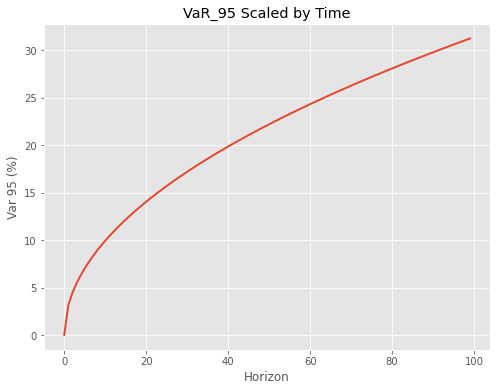

In [29]:
# Scaled VaR over different time horizon
plt.figure(figsize=(8,6))
plt.plot(range(100),[-100*VaR_95*np.sqrt(x) for x in range(100)])
plt.xlabel('Horizon')
plt.ylabel('Var 95 (%)')
plt.title('VaR_95 Scaled by Time');

In [30]:
# Calculate CVar
CVaR_90 = returns['AMZN'][returns['AMZN']<=hVaR_90].mean()
CVaR_95 = returns['AMZN'][returns['AMZN']<=hVaR_95].mean()
CVaR_99 = returns['AMZN'][returns['AMZN']<=hVaR_99].mean()

In [31]:
ctable = [['90%', CVaR_90],['95%', CVaR_95],['99%', CVaR_99] ]
cheader = ['Confidence Level', 'Conditional Value At Risk']
print(tabulate(ctable,headers=cheader))

Confidence Level      Conditional Value At Risk
------------------  ---------------------------
90%                                  -0.0342474
95%                                  -0.0449241
99%                                  -0.0741031


In [32]:
# Weights from Minimum Variance Portfolio
wts = np.array([28.35, 17.41, 8.63, 42.57, 3.05])/100.
# wts = np.array([20, 20, 20, 20, 20])/100.
wts = wts[:, np.newaxis]
wts

array([[0.2835],
       [0.1741],
       [0.0863],
       [0.4257],
       [0.0305]])

In [33]:
# Subsume position into a dataframe
shares = pd.DataFrame((wts * 1000).astype(int), index=df.columns, columns =['quantity'])
shares['price'] = df.iloc[-1]
shares['pos'] = shares.quantity * shares.price
shares

,quantity,price,pos
AAPL,283,147.039993,4.161232e+04
AMZN,174,115.540001,2.010396e+04
FB,86,170.880005,1.469568e+04
GOOG,425,2403.370117,1.021432e+06
NFLX,30,186.979996,5.609400e+03


In [34]:
# Portfolio returns
port_ret = np.dot(returns, wts)
port_mean = port_ret.mean()
port_mean

0.0010190498265291153

In [35]:
# Portfolio volatility
port_stdev = np.sqrt(multi_dot([wts.T, returns.cov(), wts]))
port_stdev.flatten()[0]

0.014891684145856565

In [36]:
# Calculate Portfolio VaR at difference confidence level
pVaR_90 = norm.ppf(1-0.90,port_mean,port_stdev).flatten()[0]
pVaR_95 = norm.ppf(1-0.95,port_mean,port_stdev).flatten()[0]
pVaR_99 = norm.ppf(1-0.99,port_mean,port_stdev).flatten()[0]

In [37]:
# Ouput results in tabular format
ptable = [['90%', pVaR_90],['95%', pVaR_95],['99%', pVaR_99]]
header = ['Confidence Level', 'Value At Risk']
print(tabulate(ptable,headers=header))

Confidence Level      Value At Risk
------------------  ---------------
90%                      -0.0180654
95%                      -0.0234756
99%                      -0.0336242


In [38]:
# Iterate over symbols
for stock in df.columns:
    pos = df[stock].iloc[-1] * shares.T[stock]['quantity']
    pvar = VaR(stock)
    
    print(f'{stock} Holding Value: {pos:0.8}') 
    print(f'{stock} VaR at 95% confidence level: {100*pvar:0.8}%')
    print()

print(f'Portfolio Holding Value: {shares.pos.sum():0.8}')
print(f'Portoflio VaR at 95% confidence level: {100*pVaR_95:0.3}%')

AAPL Holding Value: 41612.318
AAPL VaR at 95% confidence level: -2.87%

AMZN Holding Value: 20103.96
AMZN VaR at 95% confidence level: -3.14%

FB Holding Value: 14695.68
FB VaR at 95% confidence level: -3.93%

GOOG Holding Value: 1021432.3
GOOG VaR at 95% confidence level: -2.6%

NFLX Holding Value: 5609.3999
NFLX VaR at 95% confidence level: -4.89%

Portfolio Holding Value: 1103453.7
Portoflio VaR at 95% confidence level: -2.35%
